# Sommaire

* [Imports](#chapter1)
* [Decision Tree for 2 artists](#chapter2)
* [Naive Bayes for 2 artists](#chapter3)
* [Naive Bayes for 6 artists](#chapter4)
* [SVM for 6 artists](#chapter5)
* [Random Forest for 6 artists](#chapter6)
* [Conclusion](#chapter7)
* [For further : attempt of neural network](#chapter8)

### Imports <a class="anchor" id="chapter1"></a>

In [27]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import collections

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 

if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()
os.chdir(root)


### Decision Tree for 2 artists <a class="anchor" id="chapter2"></a>

#### Pre-processing the data : the tf-idf matrix

Selection of the artist for which we will create the tf-idf matrix ad test the decision tree model

In [11]:
artist1 = 'Drake'
artist2 = 'Kanye West'

df_artist1 = pd.read_csv(f'2A - Projet Python/artist_data/discography_Drake')
df_artist2 = pd.read_csv(f'2A - Projet Python/artist_data/discography_Kanye West')

df_artist1 = df_artist1[df_artist1['Clean Lyrics'].notna()]
df_artist2 = df_artist2[df_artist2['Clean Lyrics'].notna()]

Creation of the tf-idf matrix

In [68]:
# Apply TF-IDF to the data
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(list(df_artist1['Clean Lyrics'])+list(df_artist2['Clean Lyrics']))
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

# Create and store the TF-IDF matrix
tfidf = pd.DataFrame(denselist, columns=feature_names,
                                 index=list(df_artist1['song_id'])+list(df_artist2['song_id'])).reset_index()

Adding a target value in order to enable the training

In [69]:
def artist1_indicator(index):
    for id_ in df_artist1['song_id']:
        if int(index) == int(id_):
            return 1
    return 0

tfidf = pd.concat([tfidf,pd.DataFrame([artist1_indicator(index) for index in list(tfidf['level_0'])])],axis =1).drop(['level_0'],axis = 1)
tfidf.to_csv(f'2A - Projet Python/tfidf_data/tfidf_{artist1}_{artist2}')

We have now created a tf-idf matrix fitted for experimenting

Let us try a decision tree in order to see if we can learn to differentiate songs from Drake from songs from Kayne West. 

#### The decision tree model

We splitted our dataset between the training and test set following 80%/20% proportions.

Progressing... | 0/500
Progressing... | 50/500
Progressing... | 100/500
Progressing... | 150/500
Progressing... | 200/500
Progressing... | 250/500
Progressing... | 300/500
Progressing... | 350/500
Progressing... | 400/500
Progressing... | 450/500


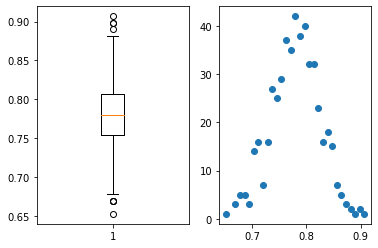

Average Accuracy :  0.7795932203389829


In [70]:
#initialisation:
n_rep = 500

list_accuracy = []
for j in range(n_rep):
    
    if j%(nbr_rep/10) == 0 :
        print('Processing... |',f'{j}/{nbr_rep}')
        
    tfidf = tfidf.sample(frac=1)
    
    rows, columns = tfidf.shape
    b = columns - 1
    X_train = tfidf.iloc[:, :-1][:int(rows // (10 / 8))] 
    X_test = tfidf.iloc[:, :-1][int(rows // (10 / 8)):] 
    y_train = tfidf.iloc[:, b:][:int(rows // (10 / 8))] 
    y_test = tfidf.iloc[:, b:][int(rows // (10 / 8)):]
    
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier()
    
    # Train Decision Tree Classifer
    clf = clf.fit(X_train, y_train)
    
    # Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    compteur = 0
    y_test_ = [y for y in y_test[0]]
    for i in range(len(y_pred)):
        if y_pred[i] == y_test_[i]:
            compteur += 1
    list_accuracy.append(compteur / len(y_pred))

plt.subplot(1,2,1)
plt.boxplot(list_accuracy)
plt.subplot(1,2,2)
plt.scatter(pd.DataFrame.from_dict(dict(collections.Counter(list_accuracy)),orient='index').reset_index()['index'],
        pd.DataFrame.from_dict(dict(collections.Counter(list_accuracy)),orient='index').reset_index()[0])
plt.show()

print('Average Accuracy : ',np.mean(list_accuracy))

### Decision Tree for N Artists

#### Pre-processing the data

Collecting data for our 6 artists

In [72]:
list_artists = ['Bruno Mars','Adele','Eminem','Kanye West','Drake','Lana Del Rey']

df_artists = pd.DataFrame()

for artist in list_artists:
    df = pd.read_csv(f'2A - Projet Python/artist_data/discography_{artist}')
    df_artists = pd.concat([df_artists,df[df['Clean Lyrics'].notna()]], axis = 0)

We once again create a tf-idf matrix, but this time for our 6 artists

In [73]:
# Apply TF-IDF to the data
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(list(df_artists['Clean Lyrics']))
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

# Create and store the TF-IDF matrix
tfidf = pd.DataFrame(denselist, columns=feature_names, index=list(df_artists['song_id'])).reset_index()

We add our target value for the model

In [74]:
def artist_indicator(index):
    return df_artists[df_artists['song_id'] == index]['Artist'].values[0]

tfidf = pd.concat([tfidf,pd.DataFrame([artist_indicator(index) for index in list(tfidf['level_0'])])],axis =1).drop(['level_0'],axis = 1)

tfidf.to_csv(f'2A - Projet Python/tfidf_data/global_tfidf')

#### The Decision Tree model

Progress ... |  0/500
Progress ... |  50/500
Progress ... |  100/500
Progress ... |  150/500
Progress ... |  200/500
Progress ... |  250/500
Progress ... |  300/500
Progress ... |  350/500
Progress ... |  400/500
Progress ... |  450/500


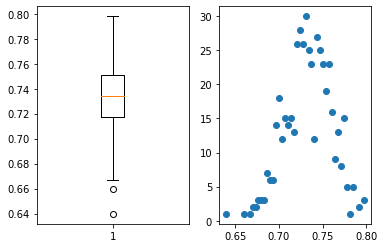

Average Accuracy :  0.7329898989898991


In [77]:
#Initialisation : 
n_rep = 500

list_accuracy = []
for j in range(n_rep):
    tfidf = tfidf.sample(frac=1)

    if j%(n_rep/10) ==0 :
        print('Progress ... | ',f'{j}/{n_rep}')

    rows, columns = tfidf.shape
    b = columns - 1
    X_train = tfidf.iloc[:, :-1][:int(rows // (10 / 8))]
    X_test = tfidf.iloc[:, :-1][int(rows // (10 / 8)):]
    y_train = tfidf.iloc[:, b:][:int(rows // (10 / 8))]
    y_test = tfidf.iloc[:, b:][int(rows // (10 / 8)):]

    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier()

    # Train Decision Tree Classifer
    clf = clf.fit(X_train, y_train)

    # Predict the response for test dataset
    y_pred = clf.predict(X_test)

    compteur = 0
    y_test_ = [y for y in y_test[0]]
    for i in range(len(y_pred)):
        if y_pred[i] == y_test_[i]:
            compteur += 1
    list_accuracy.append(compteur / len(y_pred))

plt.subplot(1,2,1)
plt.boxplot(list_accuracy)
plt.subplot(1,2,2)
plt.scatter(pd.DataFrame.from_dict(dict(collections.Counter(list_accuracy)),orient='index').reset_index()['index'],
        pd.DataFrame.from_dict(dict(collections.Counter(list_accuracy)),orient='index').reset_index()[0])
plt.show()

print('Average Accuracy : ',np.mean(list_accuracy))

## Naive Bayes for 2 artists <a class="anchor" id="chapter3"></a>

Let us try with another algorithm. 

In [25]:
artist_names = ["Drake", "Kanye West"] # enter artists' names present in the directory artist_data
nb_artists = len(artist_names)

In [26]:
X = []
Y = []

for artist in artist_names:
    data = pd.read_csv(f'./artist_data/discography_{artist}')
    data["Clean Lyrics"] = data["Clean Lyrics"].values.astype('U')
    X += data["Clean Lyrics"].values.tolist()
    for i in range(len(data)):
        Y.append(artist)
        
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.10,random_state=42)

pipeline = make_pipeline(CountVectorizer(), TfidfTransformer(), MultinomialNB())

pipeline.fit(X_train,y_train)

pipeline.score(X_test,y_test).round(3)

0.75

### Our confusion matrix

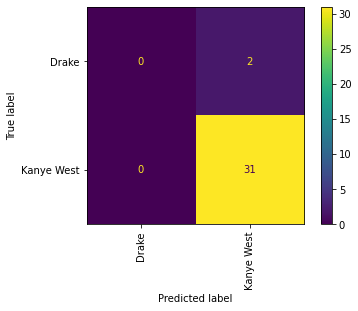

In [11]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, xticks_rotation='vertical')

## Naive Bayes for 6 artists <a class="anchor" id="chapter4"></a>

Let us now try to differentiate songs between 6 artists. 

In [21]:
artist_names = ["Adele", "Bruno Mars", "Drake", "Eminem", "Kanye West", "Lana Del Rey"] 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2,random_state=42)
nb_artists = len(artist_names)

In [40]:
X = []
Y = []

for artist in artist_names:
    data = pd.read_csv(f'./artist_data/discography_{artist}')
    data["Clean Lyrics"] = data["Clean Lyrics"].values.astype('U')
    X += data["Clean Lyrics"].values.tolist()
    for i in range(len(data)):
        Y.append(artist)
        
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.10,random_state=42)

pipeline = make_pipeline(CountVectorizer(), TfidfTransformer(), MultinomialNB())

pipeline.fit(X_train,y_train)

pipeline.score(X_test,y_test).round(3)

0.75

In [50]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, xticks_rotation='vertical')

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'

## SVM for 6 artists <a class="anchor" id="chapter5"></a>

In [12]:
artist_names = ["Adele", "Bruno Mars", "Drake", "Eminem", "Kanye West", "Lana Del Rey"] 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2,random_state=42)
nb_artists = len(artist_names)

In [19]:
X = []
Y = []

for artist in artist_names:
    data = pd.read_csv(f'./artist_data/discography_{artist}')
    data["Clean Lyrics"] = data["Clean Lyrics"].values.astype('U')
    X += data["Clean Lyrics"].values.tolist()
    for i in range(len(data)):
        Y.append(artist)

In [20]:
from sklearn.svm import SVC

clf = make_pipeline(CountVectorizer(), TfidfTransformer(), SVC(decision_function_shape = "ovr"))
clf.fit(X_train,y_train)

clf.score(X_test,y_test).round(2)

0.92

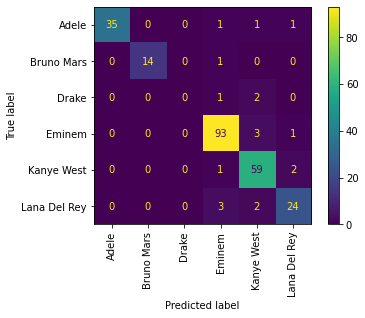

In [21]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=clf.classes_, xticks_rotation='vertical')

## Random Forest for 6 artists <a class="anchor" id="chapter6"></a>

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rand_forest = make_pipeline(CountVectorizer(), TfidfTransformer(), RandomForestClassifier())
rand_forest.fit(X_train,y_train)

rand_forest.score(X_test,y_test).round(2)

0.88

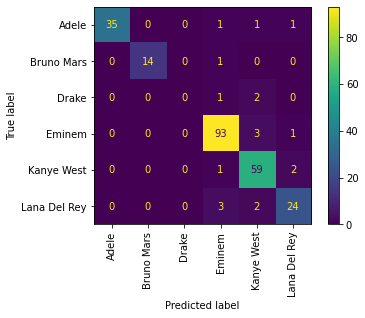

In [23]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=rand_forest.classes_, xticks_rotation='vertical')

## Conclusion <a class="anchor" id="chapter7"></a>

The model with the score seems to be the random forest withe 0.87.

## For further : attempt of neural network <a class="anchor" id="chapter8"></a>

Given the lower scores observed when we try to work with more than 2 artists, we tried to look for deep-learning model, however the parameters still need to be improved...

In [41]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, SpatialDropout1D, LSTM

In [42]:
artist_names = ["Drake", "Adele", "Lana Del Rey","Eminem"]
nb_artists = len(artist_names)

In [45]:
X = []
Y = []

def tokenized_lyrics(lyrics):
    return word_tokenize(str(lyrics))

for artist in artist_names:
    data = pd.read_csv(f'./artist_data/discography_{artist}')
    data['CTL2'] = data['Clean Lyrics'].apply(tokenized_lyrics)
    X += (data["CTL2"].values.tolist())
    for i in range(len(data)):
        one_h = np.zeros(nb_artists) 
        artist_index = artist.index(artist)
        one_h[artist_index] = 1
        Y.append(one_h)
        
# Tokenize the songs in the X vector
word_tokens = {}
for song in X:
    for word in song: 
        if word not in word_tokens.keys():
            if (len(word_tokens.keys()) == 0):
                word_tokens[word] = 1
            else:
                word_tokens[word] = len(word_tokens) + 1
                
token_x = []
for song in X:
    new_song = []
    for word in song:
        new_song.append(word_tokens[word])
    token_x.append(np.array(new_song))
X = token_x

# We removed the songs that have less then 100 words
cutoff = 100
new_x = []
new_y = []
for i in range(len(X)):
    if (len(X[i]) >= cutoff):
        new_x.append(X[i])
        new_y.append(Y[i])
X = new_x
Y = new_y

# We keep 100 words for each song
trimmed = []
for song in X:
    song = song[:100]
    trimmed.append(song)
X = trimmed

# Conversion to numpy-array
X = np.array(X)
Y = np.array(Y)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [47]:
model = Sequential([
    Dense(128, input_shape=(100,)),
    Activation('softmax'),
    Dense(1500),
    Activation('softmax'),
    Dense(500),
    Activation('relu'),
    Dense(225),
    Activation('relu'),
    Dense(64),
    Activation('softmax'),
    Dense(nb_artists)
])

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               12928     
                                                                 
 activation_20 (Activation)  (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 1500)              193500    
                                                                 
 activation_21 (Activation)  (None, 1500)              0         
                                                                 
 dense_26 (Dense)            (None, 500)               750500    
                                                                 
 activation_22 (Activation)  (None, 500)               0         
                                                                 
 dense_27 (Dense)            (None, 225)              

In [48]:
epochs = 900
batch_size = 24
model.fit(X_train,
          y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=0.1,
          verbose=0)

In [49]:
model.evaluate(X_train, y_train, verbose=False)

[7.496910257032141e-07, 1.0]